In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as plt

from fairpair import *

## Load and Select Data

In [2]:
# load the already processed data

data = pd.read_csv('./correlations_combined.csv.bz2', compression='bz2')

In [3]:
# select a subset of the data to investigate

sampling_method = 'RandomSampling' # RandomSampling, OversampleMinority, or RankSampling
ranking_method = "David's Score" # GNNRank, David's Score, RankCentrality, or Fairness-Aware PageRank
bias_applied = True # True or False

filtered_df = data[data['sampling method'] == sampling_method]
filtered_df = filtered_df[filtered_df['ranking method'] == ranking_method] 
filtered_df = filtered_df[filtered_df['bias_applied'] == bias_applied]
filtered_df = filtered_df.reset_index(drop=True)
filtered_df

,iteration,skill score,average perceived score,rank,group,sampling method,bias_applied,ranking method
0,30,0.262491,0.262491,180,Privileged,RandomSampling,True,David's Score
1,30,-0.895870,-0.895870,323,Privileged,RandomSampling,True,David's Score
2,30,0.646459,0.646459,37,Privileged,RandomSampling,True,David's Score
3,30,0.810228,0.810228,56,Privileged,RandomSampling,True,David's Score
4,30,-1.680674,-1.680674,140,Privileged,RandomSampling,True,David's Score
...,...,...,...,...,...,...,...,...
39195,1000,0.119085,-1.702029,314,Unprivileged,RandomSampling,True,David's Score
39196,1000,0.654799,-0.503854,122,Unprivileged,RandomSampling,True,David's Score
39197,1000,0.197449,-1.408256,266,Unprivileged,RandomSampling,True,David's Score
39198,1000,0.456612,-0.981337,242,Unprivileged,RandomSampling,True,David's Score


In [4]:
# re-construct an empty comparison graph and label nodes
# we need this for the evaluation of accuracy, group exposure, and group-conditioned accuracy later

G = FairPairGraph()
G.add_nodes_from(range(400))
skill_scores = dict(filtered_df[filtered_df.iteration == filtered_df.iteration.min()]['skill score'])
nx.set_node_attributes(G, skill_scores, 'skill')
minority = dict(filtered_df[filtered_df.iteration == filtered_df.iteration.min()]['group'] == 'Unprivileged')
nx.set_node_attributes(G, minority, 'minority')

## Post-Process

In [5]:
import fairsearchcore as fsc
from fairsearchcore.models import FairScoreDoc

fair = fsc.Fair(k=400, p=0.5, alpha=0.1)

In [6]:
post_processed_df = filtered_df.copy()

for iteration in filtered_df.iteration.unique():
    # get the ranking from the filtered_df
    # luckily, the nodes are always stored in the same order (in each iteration, with each sampling strategy/ranking recovery method)
    tmp_df = filtered_df[filtered_df.iteration == iteration].reset_index(drop=True)
    tmp_df['group_bin'] = tmp_df['group'] == 'Unprivileged'

    # create a list of FairScoreDoc
    ranking_list = tmp_df.reset_index()[['index', 'rank', 'group_bin']].sort_values('rank').to_numpy()
    fair_score_list = [FairScoreDoc(entry[0], 400-entry[1], entry[2]) for entry in ranking_list]
    #for entry in fair_score_list:
    #    print(entry.id, entry.score, entry.is_protected)

    # apply the FA*IR re-ranking algorithm
    re_ranked_list = fair.re_rank(fair_score_list)
    #for entry in re_ranked_list:
    #    print(entry.id, entry.score, entry.is_protected)

    # re-format output to fit into the DataFrame
    post_processed_ranking = [(entry.id, i) for i, entry in enumerate(re_ranked_list)]
    post_processed_ranking = [rank for id, rank in sorted(post_processed_ranking, key=lambda x: x[0])]
    
    # put the post-processed ranking back into the dataframe
    post_processed_df.loc[post_processed_df.iteration == iteration, 'new_rank'] = post_processed_ranking

In [7]:
post_processed_df[post_processed_df.iteration==500].sort_values('new_rank').head(10)

,iteration,skill score,average perceived score,rank,group,sampling method,bias_applied,ranking method,new_rank
18830,500,1.844873,1.844873,0,Privileged,RandomSampling,True,David's Score,0.0
18939,500,2.510079,2.510079,1,Privileged,RandomSampling,True,David's Score,1.0
18938,500,1.720037,1.720037,2,Privileged,RandomSampling,True,David's Score,2.0
18962,500,1.833521,1.833521,3,Privileged,RandomSampling,True,David's Score,3.0
18955,500,1.522942,1.522942,4,Privileged,RandomSampling,True,David's Score,4.0
18926,500,1.260528,1.260528,5,Privileged,RandomSampling,True,David's Score,5.0
19026,500,2.168619,0.962149,17,Unprivileged,RandomSampling,True,David's Score,6.0
18990,500,1.484812,1.484812,6,Privileged,RandomSampling,True,David's Score,7.0
18980,500,1.125025,1.125025,7,Privileged,RandomSampling,True,David's Score,8.0
19048,500,2.502503,1.359177,19,Unprivileged,RandomSampling,True,David's Score,9.0


## Evaluate

In [16]:
# evaluate the post-processed rankings

accuracy = []
for iteration in post_processed_df.iteration.unique():
    # get the ranking from the post_processed_df
    tmp_df = post_processed_df[post_processed_df.iteration == iteration].reset_index(drop=True)
    ranking = {key:(400-value) for key, value in enumerate(tmp_df['new_rank'])} # we invert the ranks for evaluation

    tau = weighted_tau(G, ranking)
    accuracy.append((iteration, tau, bias_applied, sampling_method, ranking_method, 'tau', 'Overall'))
    tau = weighted_tau(G, ranking, G.majority)
    accuracy.append((iteration, tau, bias_applied, sampling_method, ranking_method, 'tau', 'Privileged'))
    tau = weighted_tau(G, ranking, G.minority)
    accuracy.append((iteration, tau, bias_applied, sampling_method, ranking_method, 'tau', 'Unprivileged'))
    tau = weighted_tau_separate(G, ranking, G.majority)
    accuracy.append((iteration, tau[0], bias_applied, sampling_method, ranking_method, 'tau', 'Privileged within-group'))
    accuracy.append((iteration, tau[1], bias_applied, sampling_method, ranking_method, 'tau', 'Between groups'))
    tau = weighted_tau_separate(G, ranking, G.minority, calc_between=False)
    accuracy.append((iteration, tau[0], bias_applied, sampling_method, ranking_method, 'tau', 'Unprivileged within-group'))
    exp = exposure(G, ranking, G.majority)
    accuracy.append((iteration, exp, bias_applied, sampling_method, ranking_method, 'exposure', 'Privileged'))
    exp = exposure(G, ranking, G.minority)
    accuracy.append((iteration, exp, bias_applied, sampling_method, ranking_method, 'exposure', 'Unprivileged'))

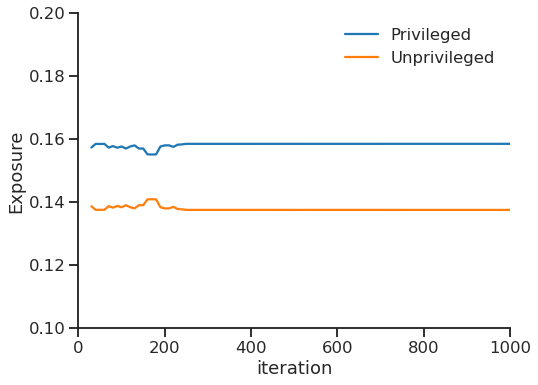

In [17]:
# plot the results
# for instance, we can plot the group representation

results_df = pd.DataFrame(data=accuracy, columns=['iteration', 'value', 'bias_applied', 'sampling strategy', 'recovery method', 'metric', 'group'])

# some settings for seaborn
palette = sns.color_palette('tab10')
sns.set(rc={'figure.figsize':(4/3*5.8,5.8)})
sns.set_context("talk") # larger font size
sns.set_style('ticks')

# select which metric to plot – tau or exposure
df = results_df.loc[results_df.metric == 'exposure'].copy()

# rename the value to the name of the metric
#df['Weighted Kemeny distance'] = df.value
df['Exposure'] = df.value

with sns.color_palette(palette):
    ax = sns.lineplot(df, x='iteration', y='Exposure', hue='group',
                      hue_order=['Privileged', 'Unprivileged']) # select which groups to plot

#ax.get_legend().remove()
sns.move_legend(ax, "upper right", frameon=False, title=None)
ax.set(xlim=(0,1000), ylim=(0.1,0.2))
sns.despine()
#plt.savefig(f'./plots/accuracy_{sampling_method}_{ranking_method}_{"noBias" if not bias_applied else ""}.png', dpi=150, bbox_inches="tight")
#plt.close()